# Skin Lesion Classification

In [4]:
!pip install torch torchvision opencv-python scikit-image scikit-learn pandas numpy matplotlib seaborn pillow statsmodels

  Using cached torch-2.9.0-cp313-none-macosx_11_0_arm64.whl.metadata (30 kB)
  Using cached torchvision-0.24.0-cp313-cp313-macosx_12_0_arm64.whl.metadata (5.9 kB)
Using cached torch-2.9.0-cp313-none-macosx_11_0_arm64.whl (74.5 MB)
Using cached torchvision-0.24.0-cp313-cp313-macosx_12_0_arm64.whl (1.9 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [torchvision] [torchvision]


In [54]:
# Skin Lesion Classification System
# Computer Vision approach for melanoma detection using deep learning

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Computer Vision Libraries
import cv2
import skimage
from skimage import morphology, filters, measure
from skimage.segmentation import clear_border

# Deep Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
import torchvision.transforms as T

# Evaluation Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import statsmodels.api as sm

# Check device availability
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(f"Using device: {device}")


Using device: mps


In [55]:
DATA_DIR = 'ISIC-images'
METADATA_PATH = 'ham10000_metadata_2025-11-04.csv'
BATCH_SIZE = 32
NUM_EPOCHS = 25
LEARNING_RATE = 0.001
MODEL_NAME = 'resnet18'
USE_SEGMENTATION = False
NUM_WORKERS = 4

## Data Preparation

In [56]:
df = pd.read_csv(METADATA_PATH)

In [57]:
df.head()

,isic_id,attribution,copyright_license,age_approx,anatom_site_general,anatom_site_special,concomitant_biopsy,diagnosis_1,diagnosis_2,diagnosis_3,diagnosis_confirm_type,image_manipulation,image_type,lesion_id,melanocytic,sex
0,ISIC_0024306,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,45.0,NaN,NaN,False,Benign,Benign melanocytic proliferations,Nevus,serial imaging showing no change,NaN,dermoscopic,IL_7252831,True,male
1,ISIC_0024307,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,50.0,lower extremity,NaN,False,Benign,Benign melanocytic proliferations,Nevus,serial imaging showing no change,NaN,dermoscopic,IL_6125741,True,male
2,ISIC_0024308,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,55.0,NaN,NaN,False,Benign,Benign melanocytic proliferations,Nevus,serial imaging showing no change,NaN,dermoscopic,IL_3692653,True,female
3,ISIC_0024309,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,40.0,NaN,NaN,False,Benign,Benign melanocytic proliferations,Nevus,serial imaging showing no change,NaN,dermoscopic,IL_0959663,True,male
4,ISIC_0024310,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,60.0,anterior torso,NaN,True,Malignant,Malignant melanocytic proliferations (Melanoma),"Melanoma, NOS",histopathology,NaN,dermoscopic,IL_8194852,True,male


In [58]:
df = df[["isic_id", "diagnosis_1"]]

In [59]:
df.head()

,isic_id,diagnosis_1
0,ISIC_0024306,Benign
1,ISIC_0024307,Benign
2,ISIC_0024308,Benign
3,ISIC_0024309,Benign
4,ISIC_0024310,Malignant


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11720 entries, 0 to 11719
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   isic_id      11720 non-null  object
 1   diagnosis_1  11720 non-null  object
dtypes: object(2)
memory usage: 183.3+ KB


In [61]:
df['diagnosis_1'].value_counts()

diagnosis_1
Benign           9415
Malignant        2156
Indeterminate     149
Name: count, dtype: int64

In [62]:
# Remove rows with Indeterminate diagnosis

df = df[df['diagnosis_1'] != 'Indeterminate']

In [63]:
df['diagnosis_1'].value_counts()

diagnosis_1
Benign       9415
Malignant    2156
Name: count, dtype: int64

In [64]:
# Add binary label column for the diagnosis

df['diagnosis_1_bin'] = df['diagnosis_1'].map({'Malignant': 1, 'Benign': 0}).astype(int)

In [65]:
df.head()

,isic_id,diagnosis_1,diagnosis_1_bin
0,ISIC_0024306,Benign,0
1,ISIC_0024307,Benign,0
2,ISIC_0024308,Benign,0
3,ISIC_0024309,Benign,0
4,ISIC_0024310,Malignant,1


In [68]:
df[df['diagnosis_1_bin'] == 1]['diagnosis_1_bin'].head(4)

4     1
7     1
9     1
17    1
Name: diagnosis_1_bin, dtype: int64

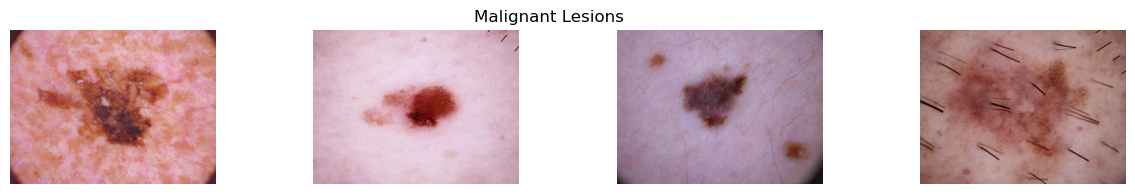

In [93]:
# Display a Malignant images

fig, axes = plt.subplots(1, 4, figsize = (15, 2))
fig.suptitle('Malignant Lesions')
idx = 0
for index, row in df[df['diagnosis_1_bin'] == 1].head(4).iterrows():
    file_path = f'ISIC-images/{row['isic_id']}.jpg'
    img = cv2.imread(file_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    axes[idx].imshow(img_rgb)
    axes[idx].axis("off")
    idx += 1
plt.show()

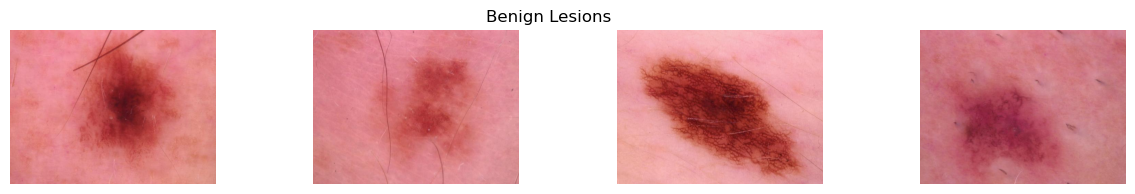

In [94]:
# Display a Benign images

fig, axes = plt.subplots(1, 4, figsize = (15, 2))
fig.suptitle('Benign Lesions')
idx = 0
for index, row in df[df['diagnosis_1_bin'] == 0].head(4).iterrows():
    file_path = f'ISIC-images/{row['isic_id']}.jpg'
    img = cv2.imread(file_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    axes[idx].imshow(img_rgb)
    axes[idx].axis("off")
    idx += 1
plt.show()

## Test-Train Split

In [95]:
df.head()

,isic_id,diagnosis_1,diagnosis_1_bin
0,ISIC_0024306,Benign,0
1,ISIC_0024307,Benign,0
2,ISIC_0024308,Benign,0
3,ISIC_0024309,Benign,0
4,ISIC_0024310,Malignant,1


In [96]:
features = df['isic_id']
target = df['diagnosis_1_bin']

In [97]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.15, random_state=42)

In [98]:
x_train.shape, x_test.shape

((9835,), (1736,))

## Custom Dataset

In [119]:
class SkinLesionDataset(Dataset):
    def __init__(self, ids, labels, img_dir, transform=None):
        self.ids = ids.values
        self.labels = labels.values
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        image_id = self.ids[idx]
        img_path = os.path.join(DATA_DIR, image_id + '.jpg')

        image = Image.open(img_path).convert("RGB")
        label = torch.tensor(self.labels[idx]).long()

        if self.transform:
            image = self.transform(image)

        return image, label

In [120]:
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

test_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [121]:
train_dataset = SkinLesionDataset(x_train, y_train, "images", train_tfms)
test_dataset  = SkinLesionDataset(x_test, y_test, "images", test_tfms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

## Load ResNet18

In [122]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/thaneesh/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████████████████████████████████| 44.7M/44.7M [00:00<00:00, 72.4MB/s]


## Loss and Optimizer

In [124]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

## Training Loop

In [125]:
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")
        

Epoch 1/5, Loss: 0.3245
Epoch 2/5, Loss: 0.2685
Epoch 3/5, Loss: 0.2423
Epoch 4/5, Loss: 0.2251
Epoch 5/5, Loss: 0.2082


## Evaluation

In [127]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print('Test Accuracy: ', accuracy)

Test Accuracy:  0.8876728110599078


In [111]:
img = cv2.imread("ISIC-images/ISIC_0024308.jpg")

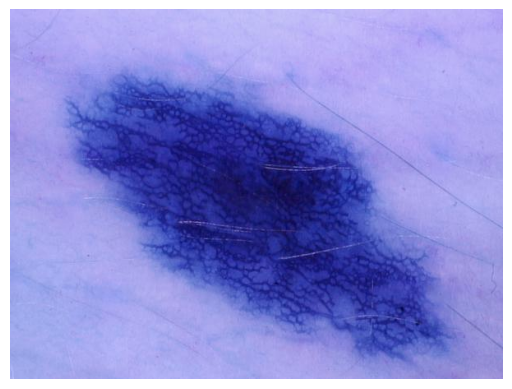

In [112]:
plt.imshow(img)
plt.axis("off")
plt.show()

In [113]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

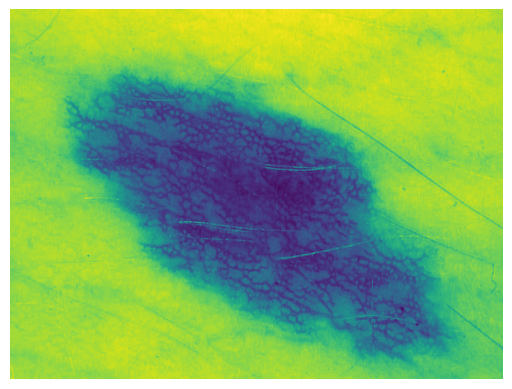

In [114]:
plt.imshow(gray)
plt.axis("off")
plt.show()

In [115]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

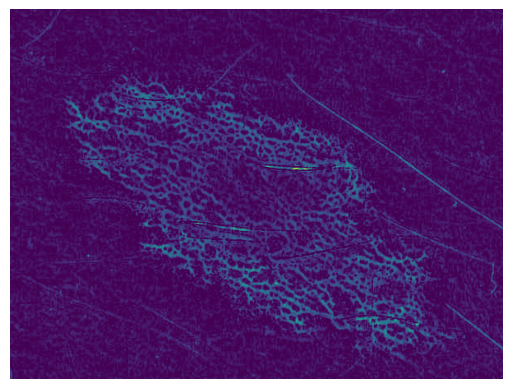

In [116]:
plt.imshow(blackhat)
plt.axis("off")
plt.show()

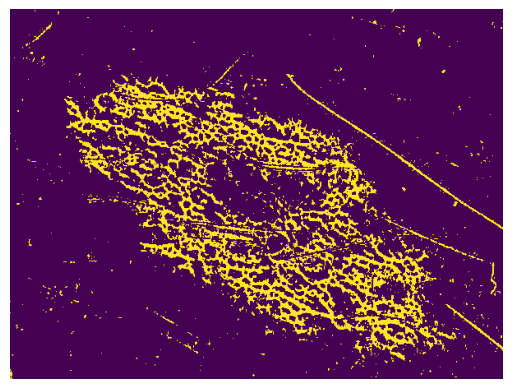

In [117]:
_, mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
plt.imshow(mask)
plt.axis("off")
plt.show()

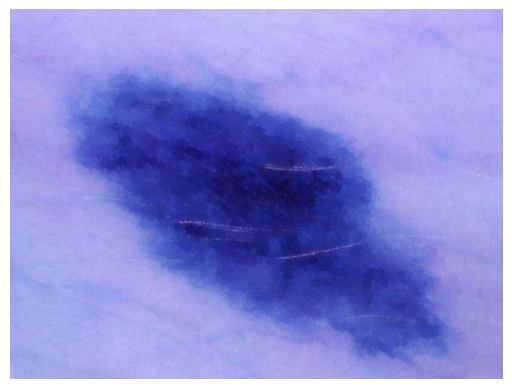

In [118]:
result = cv2.inpaint(img, mask, 6, cv2.INPAINT_TELEA)
plt.imshow(result)
plt.axis("off")
plt.show()